In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#라이브러리 설치
!pip install split-folders

In [ ]:
#Import the libraries
import zipfile
import os
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive (2)_.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/dataset') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
data_dir = '../tmp/dataset/PokemonData'
import os
classes = os.listdir(data_dir)
print(os.listdir(data_dir))
print(len(classes))

In [ ]:
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps

#다음 변수를 수정하여 새로 만들 이미지 갯수를 정합니다.
num_augmented_images = 50

file_path = '/content/drive/MyDrive/ColabNotebooks/PokemonData/'
dir_names = os.listdir(file_path)
total_origin_dir_num = len(dir_names)
print(len(dir_names))
augment_cnt = 1

for i in range(0, total_origin_dir_num):
dir_name = dir_names[i]
file_names=os.listdir(file_path+dir_name)
total_origin_image_num=len(file_names)          #폴더당 이미지 개수
for k in range(0, total_origin_image_num):      #폴더의 이미지만큼 반복
change_picture_index = k
file_name = file_names[change_picture_index]  #전환할 이미지
origin_image_path = '/content/drive/MyDrive/ColabNotebooks/PokemonData/'+dir_name +'/'+file_name
print(origin_image_path)
image = Image.open(origin_image_path)
random_augment = random.randrange(1,3)
save_image_path='/content/drive/MyDrive/ColabNotebooks/PokemonData/'+dir_name+'/'
if(random_augment == 1):
#이미지 좌우 반전
print("invert")
inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT)
inverted_image.save(save_image_path + 'inverted_' + str(augment_cnt) + '.png')   
elif(random_augment == 2):
#이미지 기울이기
print("rotate")
rotated_image = image.rotate(random.randrange(-20, 20))
rotated_image.save(save_image_path + 'rotated_' + str(augment_cnt) + '.png')

augment_cnt += 1  #파일 개수
augment_cnt=1#파일 개수 초기화

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import splitfolders

In [ ]:
#저장 경로를 drive로 해서 최초 1번만 실행
splitfolders.ratio("/content/drive/MyDrive/ColabNotebooks/PokemonData", output="/content/drive/MyDrive/ColabNotebooks/preprocessing",seed=1337, ratio=(.8, .18, .02), group_prefix=None, move=False)

In [ ]:
tf= transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))
])

#미리 드라이브에 저장해놓은 데이터를 로드
train_data=datasets.ImageFolder(root='/content/drive/MyDrive/ColabNotebooks/preprocessing/train',transform=tf)
test_data=datasets.ImageFolder(root='/content/drive/MyDrive/ColabNotebooks/preprocessing/val',transform=tf)

In [ ]:
batch_size=32
trainloader=DataLoader(train_data,batch_size=batch_size, shuffle=True)
testloader=DataLoader(test_data,batch_size=batch_size, shuffle=True)
train_images,train_labels=iter(trainloader).next()
print(train_labels)

tensor([ 91, 140,  61, 128,  97, 141, 132,  58,  27, 101,  27,  66, 134,  73,
         59,  60,  66,  77,  51,  81,  21,  63, 124, 135,  37, 119,  36,  65,
        126, 147,  71, 117])


In [ ]:
import numpy as np
import pandas as pd
import os
import torchvision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train = '/content/drive/MyDrive/ColabNotebooks/PokemonData'




#ResNet50

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

resnet50 = models.resnet50(pretrained = True)

for param in resnet50.parameters():   #가중치 freeze
  param.requires_grad = False

num_classes = 150
num_ftrs = resnet50.fc.in_features

resnet50.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)

criterion = nn.CrossEntropyLoss() 

optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size =7, gamma=0.1)

In [ ]:
from tqdm import tqdm

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    pbar = tqdm(enumerate(dataloader), total = len(dataloader)) #
    learning_loss = 0
    sum_loss = 0

    for batch, (X, y) in pbar:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss = sum_loss + loss.item() #
        learning_loss = sum_loss / (batch + 1)
        
        description = f'train loss : {round(learning_loss, 4)}'
        pbar.set_description(description)

def test(dataloader, model, loss_fn):
    model.eval()  #
    pbar = tqdm(enumerate(dataloader), total = len(dataloader)) #
    learning_loss = 0
    sum_loss = 0
    learning_acc = 0
    sum_acc = 0
    correct = 0

    for batch, (X, y) in pbar:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      loss = loss_fn(pred, y)
      correct = (pred.argmax(1)==y).type(torch.float).sum().item()
      acc = correct / batch_size
      sum_acc += acc
      learning_acc = sum_acc / (batch + 1)
      sum_loss = sum_loss + loss.item() #
      learning_loss = sum_loss / (batch + 1)

      description = f'test loss : {learning_loss}  || test acc : {learning_acc}'
      pbar.set_description(description)

    return learning_acc

In [ ]:
epochs = 20
best_acc = 0

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(trainloader,resnet50,criterion,optimizer_ft)
  acc = test(testloader,resnet50,criterion)
  if acc > best_acc:
    best_acc = acc
    torch.save(resnet50.state_dict(),f'/content/drive/MyDrive/ColabNotebooks/pokemonmodel_{acc}.pt') #(모델의 현재 파라미터저장,저장경로)

Epoch 1
-------------------------------


train loss : 0.4063: 100%|██████████| 340/340 [02:45<00:00,  2.06it/s]
test loss : 0.6631193681557973  || test acc : 0.87375: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 2
-------------------------------


train loss : 0.3973: 100%|██████████| 340/340 [02:45<00:00,  2.06it/s]
test loss : 0.6328793438275655  || test acc : 0.88: 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]


Epoch 3
-------------------------------


train loss : 0.3878: 100%|██████████| 340/340 [02:44<00:00,  2.07it/s]
test loss : 0.6251734741528829  || test acc : 0.8775: 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]


Epoch 4
-------------------------------


train loss : 0.3836: 100%|██████████| 340/340 [02:44<00:00,  2.06it/s]
test loss : 0.6154565409819285  || test acc : 0.8808333333333334: 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]


Epoch 5
-------------------------------


train loss : 0.3719: 100%|██████████| 340/340 [02:43<00:00,  2.07it/s]
test loss : 0.6200367053349812  || test acc : 0.88: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 6
-------------------------------


train loss : 0.3555: 100%|██████████| 340/340 [02:43<00:00,  2.07it/s]
test loss : 0.6011332348982493  || test acc : 0.8783333333333333: 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]


Epoch 7
-------------------------------


train loss : 0.3496: 100%|██████████| 340/340 [02:44<00:00,  2.06it/s]
test loss : 0.5799297843376795  || test acc : 0.88125: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 8
-------------------------------


train loss : 0.3446: 100%|██████████| 340/340 [02:44<00:00,  2.07it/s]
test loss : 0.5865132280190786  || test acc : 0.88875: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s]


Epoch 9
-------------------------------


train loss : 0.336: 100%|██████████| 340/340 [02:42<00:00,  2.09it/s]
test loss : 0.5676767865816752  || test acc : 0.8854166666666666: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 10
-------------------------------


train loss : 0.3333: 100%|██████████| 340/340 [02:43<00:00,  2.07it/s]
test loss : 0.5413207570711772  || test acc : 0.895: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 11
-------------------------------


train loss : 0.3184: 100%|██████████| 340/340 [02:44<00:00,  2.07it/s]
test loss : 0.5583816987276077  || test acc : 0.8933333333333333: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 12
-------------------------------


train loss : 0.317: 100%|██████████| 340/340 [02:42<00:00,  2.09it/s]
test loss : 0.5230196313063303  || test acc : 0.8966666666666666: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 13
-------------------------------


train loss : 0.3036: 100%|██████████| 340/340 [02:44<00:00,  2.07it/s]
test loss : 0.5202274831136068  || test acc : 0.8991666666666667: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 14
-------------------------------


train loss : 0.3013: 100%|██████████| 340/340 [02:43<00:00,  2.07it/s]
test loss : 0.535297878185908  || test acc : 0.8883333333333333: 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]


Epoch 15
-------------------------------


train loss : 0.2963: 100%|██████████| 340/340 [02:43<00:00,  2.09it/s]
test loss : 0.5423712788025538  || test acc : 0.8891666666666667: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 16
-------------------------------


train loss : 0.2865: 100%|██████████| 340/340 [02:44<00:00,  2.07it/s]
test loss : 0.531057418982188  || test acc : 0.89125: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s]


Epoch 17
-------------------------------


train loss : 0.2848: 100%|██████████| 340/340 [02:42<00:00,  2.09it/s]
test loss : 0.5068185339371364  || test acc : 0.8991666666666667: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 18
-------------------------------


train loss : 0.28: 100%|██████████| 340/340 [02:42<00:00,  2.09it/s]
test loss : 0.490044325987498  || test acc : 0.905: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 19
-------------------------------


train loss : 0.2756: 100%|██████████| 340/340 [02:44<00:00,  2.07it/s]
test loss : 0.49040355046590167  || test acc : 0.9: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]


Epoch 20
-------------------------------


train loss : 0.2702: 100%|██████████| 340/340 [02:42<00:00,  2.09it/s]
test loss : 0.5138180363178253  || test acc : 0.8929166666666667: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


#pokemon 판별

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install cvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.7 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046385 sha256=a4a070b680f5511c4399b66a89048ed2b5044f9d1673cf2cefa4ab6421d24d45
  Stored in directory: /root/.cache/pip/wheels/8e/d7/31/bc643bd3a8b11a7368b1ab1d8a6299b33b462ed0b0683ddc5a
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=aac182f74ccfe9c7de766bb4d55327234b294ea3d3ec69d03c98baa8a6ed7a9a
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

path = '/content/drive/MyDrive/ColabNotebooks/pokemonmodel_0.905.pt'

resnet50 = models.resnet50(pretrained = True)
for param in resnet50.parameters():   #가중치 freeze
  param.requires_grad = False

num_classes = 150
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)


resnet50.load_state_dict(torch.load(path))
resnet50.eval()  #Dropout, Batchnorm 등의 기능 비활성화

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

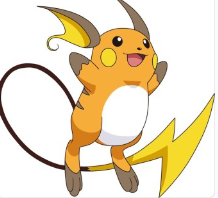

Raichu


In [ ]:
import cv2
import cvlib as cv
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import os

img = cv2.imread('12341.PNG')
cv2_imshow(img)
img = Image.fromarray(img)

tf = transforms.Compose([
                         transforms.Resize((224,224)),  
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,),(0.5,))
])


img = tf(img).unsqueeze(0)  #resnet50에 넣기 위해 4D로 변환 후 모델에 넣기위해 transform
img = img.to(device)  
pred = resnet50(img)
pokemon = pred.argmax(1)
pokemon = int(pokemon)

classes = os.listdir('/content/drive/MyDrive/ColabNotebooks/preprocessing/test')
classes.sort()
print(classes[pokemon])